## Basic regression of retirement value

In [118]:
import os
import sys
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from lightgbm import LGBMRegressor


PROJECT_NAME = 'UFAL-DS'
curdir = os.path.abspath(os.path.curdir).split('/')
project_index = curdir.index(PROJECT_NAME)
os.chdir('/' + os.path.join(*curdir[:project_index + 1]))

## Data

In [78]:
aposentados = pd.read_csv("data/processed/aposentados.csv")
abono = pd.read_csv("data/processed/abono.csv")

aposentados = aposentados.drop_duplicates(subset=['name', 'cpf'], keep='first')
abono = abono.drop_duplicates(subset=['name', 'cpf'], keep='first')

aposentados["retirement_year"] = pd.to_datetime(aposentados.retirement_date).dt.year

use_cols = [
    'registration_n', 'agency_acronym', 'superior_agency_cod', 
    'classes', 'pattern', 'ref', 'level', 'retirement_type', 
    'legal_substantiation', 'doc_title', 'retirement_date',
    'admission_type', 'admission_date', 'value'
]
data = abono.merge(aposentados[['name', 'cpf'] + use_cols], left_on=['name', 'cpf'], right_on=['name', 'cpf'])

data.shape

(20819, 29)

In [85]:
data.loc[data.role.str.contains("medico"), "role_gp"] = "medico"
data.loc[data.role.str.contains("psicologo"), "role_gp"] = "medico"
data.loc[data.role.str.contains("odont"), "role_gp"] = "medico"
data.loc[data.role.str.contains("tecnico"), "role_gp"] = "tecnico"
data.loc[data.role.str.contains("tec"), "role_gp"] = "tecnico"
data.loc[data.role.str.contains("professor"), "role_gp"] = "professor"
data.loc[data.role.str.contains("agente"), "role_gp"] = "agente"
data.loc[data.role.str.contains("ag "), "role_gp"] = "agente"
data.loc[data.role.str.contains("aux"), "role_gp"] = "auxiliar"
data.loc[data.role.str.contains("analista"), "role_gp"] = "analista"
data.loc[data.role.str.contains("assistente"), "role_gp"] = "assistente"
data.loc[data.role.str.contains("operador"), "role_gp"] = "operador"
data.loc[data.role.str.contains("policia"), "role_gp"] = "policia"
data.loc[data.role.str.contains("engenhe"), "role_gp"] = "engenheiro"
data.loc[data.role.str.contains("especialista"), "role_gp"] = "especialista"
data.loc[data.role.str.contains("servente"), "role_gp"] = "servente"
data.loc[data.role.str.contains("auditor"), "role_gp"] = "auditor"
data.loc[data.role.str.contains("administrador"), "role_gp"] = "administrador"
data.loc[data.role.str.contains("motorista"), "role_gp"] = "motorista"
data.loc[data.role.str.contains("datilografo"), "role_gp"] = "datilografo" 

data.loc[data.role_gp.isna(), "role_gp"] = "outros" 

In [87]:
data['role_gp'].value_counts()

agente           4940
tecnico          4033
outros           2673
auxiliar         2393
professor        1656
assistente       1105
medico           1082
auditor           650
datilografo       603
analista          539
motorista         508
administrador     169
engenheiro        167
policia           162
servente           68
operador           52
especialista       19
Name: role_gp, dtype: int64

In [108]:
data["diff_state"] = data.apply(lambda row: 1 if row["upag_state"] == row["state"] else 0, axis=1)
data["year_admission"] = pd.to_datetime(data["admission_date"]).dt.year
data["month_admission"] = pd.to_datetime(data["admission_date"]).dt.month

## Pipeline

In [260]:
numeric_features = [
    "years", "months", "level", "superior_agency_cod", 
    "diff_state", "year_admission", "month_admission"
]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())]
)

cat_features_ordinal = [
    "status", "role_gp", "admission_type", 
    "educational_level", "classes",  "retirement_type"
]

cat_features_hot = [
    "city", "status", "agency_acronym",
    "role_gp", "admission_type", "educational_level", 
    "classes", "pattern", "retirement_type"
]
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, cat_features_hot)]
)

X = data[numeric_features + cat_features_hot]
y = data["value_y"]

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LGBMRegressor())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.580


In [261]:
y_pred = clf.predict(X_test)
print("R2", r2_score(y_test, y_pred))
print("RMSE", mean_squared_error(y_test, y_pred) ** 0.5)

R2 0.5801168060775957
RMSE 3475.014180344631


## Similar model for explanability

In [175]:
import shap

In [231]:
numeric_features = [
    "years", "months", "level", "superior_agency_cod", 
    "diff_state", "year_admission", "month_admission"
]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())]
)

cat_features_ordinal = [
    "status", "role_gp", "admission_type", "gender",
    "educational_level", "classes",  "retirement_type"
]
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OrdinalEncoder())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, cat_features_ordinal)]
)

X = data[numeric_features + cat_features_ordinal]
y = data["value_y"]

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LGBMRegressor())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.532


In [253]:
x = clf.named_steps['preprocessor'].transform(X_test)

treeExplainer = shap.TreeExplainer(clf.steps[-1][1])
shap_values = treeExplainer.shap_values(x)

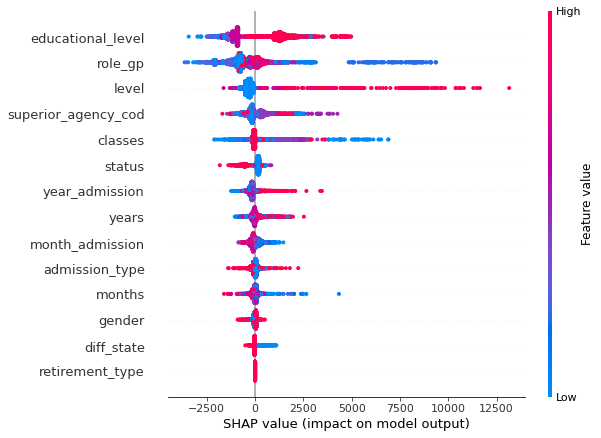

In [255]:
df = X_test.copy()
d = {i:col for i, col in enumerate(tldr.columns)}

for i in range(0, 14):
    df[d[i]] = x[:, i]
    
shap.summary_plot(shap_values, df)

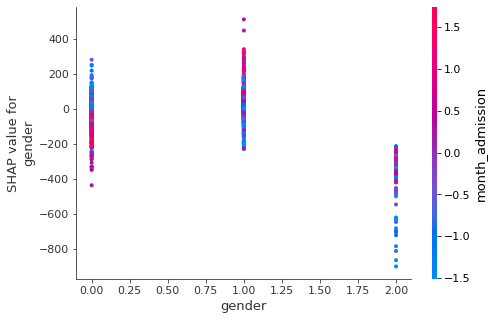

In [256]:
shap.dependence_plot("gender", shap_values, df)